In [1]:
%matplotlib inline
import pathlib as pl
import numpy as np
import sys
import xugrid
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import flopy
from flopy.export.shapefile_utils import recarray2shp
from flopy.utils.geometry import Polygon
import flopy.plot.styles as styles

# Load MF Simulation

In [2]:
to_crs_projection = "EPSG:32618"
ws = pl.Path("../pj_2018_adjust_CHDA1/base/")

sim = flopy.mf6.MFSimulation.load(sim_ws=ws, use_pandas=False)
sim.model_names

gwf = sim.get_model("gwf")
gwf.modelgrid.crs = "EPSG:4456"
gwf.package_names

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ghb...
    loading package drn...
    loading package chd...
    loading package chd...
    loading package ic...
    loading package npf...
    loading package sto...
    loading package rch...
    loading package wel...
    loading package oc...
    loading package obs...
    loading package buy...
  loading model gwt6...
    loading package dis...
    loading package fmi...
    loading package ssm...
    loading package mst...
    loading package adv...
    loading package ic...
    loading package oc...
  loading exchange package gwf-gwt_exg_0...
  loading solution package gwf...
  loading solution package gwt...


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\flopy\mf6\mfmodel.py:274: DeprecationWarning: This method is for internal use only and will be deprecated.
  warnings.warn(


['dis',
 'ghb_obs',
 'ghb',
 'drn_obs',
 'drn',
 'chd_obs',
 'chd_coast',
 'chd_perimeter',
 'ic',
 'npf',
 'sto',
 'rcha_0',
 'wel_obs',
 'wel_0',
 'oc',
 'hd_obs',
 'buy']

In [3]:
# mm = flopy.plot.PlotMapView(model=gwf, layer=0)
# mm.plot_bc("GHB")
# mm.plot_bc("chd_0")

# Create the shapefile of the chd surface data

In [4]:
fpth = pl.Path("../gis/PJ/PJ_chd_4456.shp")
chds = gwf.get_package("chd_coast")

In [5]:
chd_spd = pd.DataFrame(chds.stress_period_data.get_data(0))
print(f'{chd_spd.shape[0]} CHD cells to be coupled')

1461 CHD cells to be coupled


In [6]:
vertices = []
for k, i, j in chd_spd["cellid"]:
    vertices.append(gwf.modelgrid.get_cell_vertices(i, j))
# create polygons for the shapefile
polygons = [Polygon(vrt) for vrt in vertices]
len(polygons)

1461

In [7]:
layer = [k for k, i, j in chd_spd["cellid"]]
row = [i for k, i, j in chd_spd["cellid"]]
column = [j for k, i, j in chd_spd["cellid"]]

chd_spd["layer"] = layer
chd_spd["row"] = row
chd_spd["column"] = column
chd_spd.drop(columns=["cellid"], inplace=True)
chd_spd["chd_no"] = chd_spd.index
chd_spd

,head,salinity,boundname,layer,row,column,chd_no
0,0.330,33.9,bay,0,3,19,0
1,0.330,34.6,bay,0,3,20,1
2,0.330,34.9,bay,0,3,21,2
3,0.330,34.7,bay,0,3,22,3
4,0.330,34.7,bay,0,3,23,4
...,...,...,...,...,...,...,...
1456,0.324,34.2,surface perimeter coastal,0,22,68,1456
1457,0.324,34.4,surface perimeter coastal,0,24,70,1457
1458,0.324,34.4,surface perimeter coastal,0,26,72,1458
1459,0.324,34.4,surface perimeter coastal,0,28,74,1459


In [8]:
# Using flopy.utils.recarray2shp() to write a shapefile (.shp) and save it to the 'fpth'
# BNB note -  I don't think the line below actually assigns the crs
recarray2shp(chd_spd.to_records(index=False), geoms=polygons, shpname=fpth, crs=gwf.modelgrid.crs)

None
EPSG:4456


<Axes: >

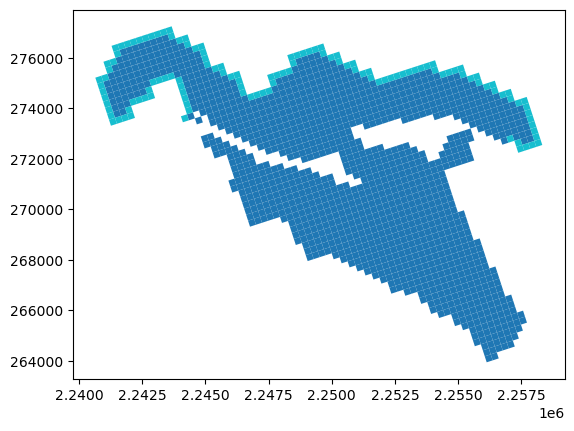

In [9]:
# Read in the shapefile that was saved in the previous cell
gdf = gpd.read_file(fpth)
print(gdf.crs)
gdf.crs = gwf.modelgrid.crs
print(gdf.crs)
fig,ax=plt.subplots()
gdf.plot(ax=ax,column='boundname')

## Remove most perimeter CHDs for coupling

In [10]:
# gdf = gdf.copy() 
# # create buffer around CHDs in the bay
# chd_buffer = gdf[gdf['boundname'] == 'bay'].buffer(1).unary_union
# # locate perimeter chd's that intersect the chd bay buffer, and remane them to 'perimeter coastal' to differentiate them from the other perimeter CHDs
# gdf.loc[(gdf['boundname'] == 'perimeter-heads') & (gdf.geometry.intersects(chd_buffer)),'boundname'] = 'perimeter coastal'
# # filter the perimeter CHDs out of the gdf
# gdf = gdf[gdf['boundname'] != 'perimeter-heads']
# # remove any cells where layer is greate than 0, because we only want coupling in the first layer. It should only be filtering out perimeter coastal CHDs because the other CHD and GHBs are only assigned at the first layer.
# gdf = gdf[gdf['layer']==0]
# gdf=gdf.reset_index()
# gdf["chd_no"] = gdf.index
# gdf.crs
# gdf.plot(column='boundname')

In [11]:
# chd_spd = gdf.copy()
# chd_spd = chd_spd.drop(columns = ['geometry'])
# chd_spd.to_csv('../gis/PJ/pj_SurfaceChd.csv')

In [12]:
# chd_spd['boundname'].unique()

In [13]:
# gdf.to_file(fpth)

## Reproject the chd surface data shapefile to UTM zone 18N

In [14]:
fpth = pl.Path("../gis/PJ/PJ_CHD_utm18n.shp")

In [15]:
# BNB Note: line commented below does not work to assign crs
#gdf.to_crs(to_crs_projection).to_file(fpth)

gdf = gdf.to_crs(to_crs_projection)
print(gdf.crs)
gdf.to_file(fpth)

assert gdf.crs == to_crs_projection

EPSG:32618


# Create the shapefile of the ghb data

In [16]:
fpth = pl.Path("../gis/PJ/PJ_ghb_4456.shp")
ghb = gwf.get_package("ghb")
ghb_spd = pd.DataFrame(ghb.stress_period_data.get_data(0))
ghb_spd["boundname"] = "estuary"
ghb_spd.rename(columns={"bhead": "head"}, errors="raise", inplace=True)
ghb_spd

,cellid,head,cond,salinity,boundname
0,"(0, 17, 26)",0.33,79.991,27.119,estuary
1,"(0, 18, 26)",0.33,239.973,27.119,estuary
2,"(0, 19, 24)",0.33,1016.210,27.119,estuary
3,"(0, 19, 25)",0.33,946.675,27.119,estuary
4,"(0, 19, 26)",0.33,315.557,27.119,estuary
...,...,...,...,...,...
349,"(0, 58, 26)",0.33,1073.377,27.119,estuary
350,"(0, 58, 27)",0.33,983.295,27.119,estuary
351,"(0, 59, 26)",0.33,775.738,27.119,estuary
352,"(0, 59, 27)",0.33,775.735,27.119,estuary


In [17]:
vertices = []
for k, i, j in ghb_spd["cellid"]:
    vertices.append(gwf.modelgrid.get_cell_vertices(i, j))
# create polygons for the shapefile
polygons = [Polygon(vrt) for vrt in vertices]
len(polygons)

354

In [18]:
layer = [k for k, i, j in ghb_spd["cellid"]]
row = [i for k, i, j in ghb_spd["cellid"]]
column = [j for k, i, j in ghb_spd["cellid"]]

ghb_spd["layer"] = layer
ghb_spd["row"] = row
ghb_spd["column"] = column
ghb_spd.drop(columns=["cellid"], inplace=True)
ghb_spd["ghb_no"] = ghb_spd.index

In [19]:
recarray2shp(ghb_spd.to_records(index=False), geoms=polygons, shpname=fpth, crs=gwf.modelgrid.crs)

None
EPSG:4456


<Axes: >

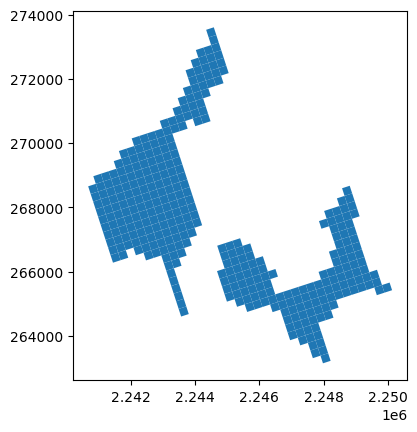

In [20]:
gdf = gpd.read_file(fpth)
print(gdf.crs)
gdf.crs = gwf.modelgrid.crs
print(gdf.crs)
gdf.plot()

## Reproject the ghb data shapefile to UTM zone 18N

In [21]:
fpth = pl.Path("../gis/PJ/PJ_ghb_utm18n.shp")

In [22]:
# BNB Note: line commented below does not work to assign crs
#gdf.to_crs(to_crs_projection).to_file(fpth)

gdf = gdf.to_crs(to_crs_projection)
print(gdf.crs)
gdf.to_file(fpth)

assert gdf.crs == to_crs_projection


EPSG:32618


# Concatenate the two dataframes to create a shapefile for plotting

In [23]:
fpth = pl.Path("../gis/PJ/PJ_chd_ghb_plot_4456.shp")

In [24]:
spd = pd.concat([chd_spd, ghb_spd])

In [25]:
spd = spd.assign(bnd_no=spd.chd_no.mask(spd.chd_no.isnull(), spd.ghb_no))

In [26]:
spd["bnd_no"] = spd["bnd_no"].astype(int)

In [27]:
vertices = []
for i, j in zip(spd["row"], spd["column"]):
    vertices.append(gwf.modelgrid.get_cell_vertices(i, j))
polygons = [Polygon(vrt) for vrt in vertices]
len(polygons)

1815

In [28]:
recarray2shp(spd.to_records(index=False), geoms=polygons, shpname=fpth, crs=gwf.modelgrid.crs)

In [29]:
gdf = gpd.read_file(fpth)
print(gdf.crs)
gdf.crs = gwf.modelgrid.crs
print(gdf.crs)

None
EPSG:4456


<Axes: >

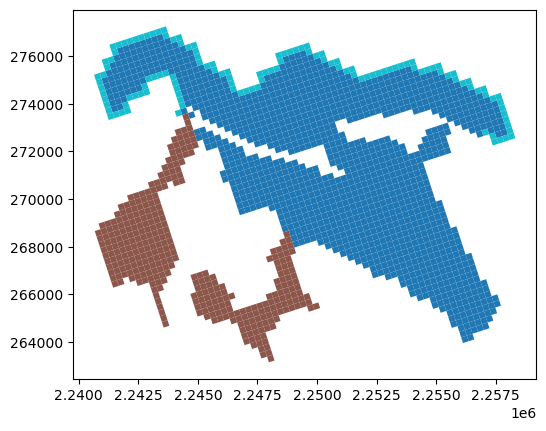

In [30]:
gdf.plot(column="boundname")

## Reproject the chd and ghb data shapefile to UTM zone 18N

In [31]:
fpth = pl.Path("../gis/PJ/PJ_coast_utm18n.shp")

In [32]:
# BNB Note: line commented below does not work to assign crs
#gdf.to_crs(to_crs_projection).to_file(fpth)

gdf = gdf.to_crs(to_crs_projection)
print(gdf.crs)
gdf.to_file(fpth)

assert gdf.crs == to_crs_projection

EPSG:32618
